### Doublet identification part 2 for mouse fetal gonads (Niu et al., 2020)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import warnings
warnings.filterwarnings('ignore')


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '/home/jovyan/Gonads/Mouse_Niu_2020/figures/doublet/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cffi                1.14.5
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.19.5
packaging           20.9
pandas              1.2.2
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.16
psutil      

'/home/jovyan/my-conda-envs/scanpy_env/bin/python'

## Scrumblet code

In [2]:
from scanpy import logging as logg
from scanpy.neighbors import neighbors
from anndata import AnnData
from scipy.sparse import csc_matrix
import numpy as np


def woublet(
        adata,
        sim_doublet_ratio=2,
        n_neighbors=30,
        expected_doublet_rate=0.1,
        total_counts_key = 'n_counts',
        copy=False):
    """ Method for detecting mixed-celltype doublets. More documentation coming. In the meantime, email Sam Wolock with questions: swolock@g.harvard.edu
    adata: scanpy AnnData data matrix
    sim_doublet_ratio: number of doublets to simulate, relative to the number of observed transcriptomes (=adata.X.shape[0])
    n_neighbors: number of neighbors used in the k-nearest-neighbor classifier
    expected_doublet_rate: expected frequency of doublets. If unknown, a reasonable guess is 0.05. This parameter rescales the doublet scores but does not affect their ordering.
    total_counts_key: name of the field in adata.obs that contains total counts per cell, used for weighting a cell's relative contribution to simulated doublets. If not present, all cells are weighted equally.
    """
    adata = adata.copy() if copy else adata

    if 'X_pca' not in adata.obsm_keys():
        raise ValueError(
            'Did not find \'X_pca\'. Run `sc.pp.pca` first.')

    if total_counts_key in adata.obs:
        total_counts = np.array(adata.obs[total_counts_key])
    else:
        total_counts = np.ones(adata.X.shape[0])

    # Simulate doublets by averaging PC coordinates of random cell pairs
    logg.info('Simulating doublets')
    PCdat, doub_labels, parent_ix = simulate_doublets_from_pca(adata.obsm['X_pca'], 
        total_counts=total_counts, 
        sim_doublet_ratio=sim_doublet_ratio)


    adata_doub = AnnData(csc_matrix((PCdat.shape[0], 1)))
    adata_doub.obsm['X_pca'] = PCdat

    # Calculate doublet scores using k-nearest-neighbor classifier
    logg.info('Running KNN classifier')
    adata.obs['doublet_score'], adata.uns['sim_doublet_score'] = calculate_doublet_scores(
        adata_doub, 
        doub_labels, 
        n_neighbors=n_neighbors, 
        expected_doublet_rate = expected_doublet_rate)

    adata.obs['doublet_score']

    return adata if copy else None



#========================================================================================#

def simulate_doublets_from_pca(PCdat, total_counts=[], sim_doublet_ratio=1):
    '''
    Simulate doublets by averaging PCA coordinates of random cell pairs.
    Average is weighted by total counts of each parent cell, if provided.

    Returns:
    PCdoub (matrix of size (num_cells+num_sim_doubs, num_pcs)): PCA matrix with the simulated doublet PCA coordinates appended to the original data matrix PCdat.
    doub_labels (array of size (num_cells+num_sim_doubs)): 0 if observed cell, 1 if simulated doublet
    pair_ix (matrix of size(num_sim_doubs, 2)): each row gives the indices of the parent cells used to generate the simulated doublet
    '''

    n_obs = PCdat.shape[0]
    n_doub = int(n_obs * sim_doublet_ratio)

    if len(total_counts) == 0:
        total_counts = np.ones(n_obs)

    pair_ix = np.random.randint(0, n_obs, size=(n_doub, 2))

    pair_tots = np.hstack((total_counts[pair_ix[:, 0]][:,None], total_counts[pair_ix[:, 1]][:,None]))
    pair_tots = np.array(pair_tots, dtype=float)
    pair_fracs = pair_tots / np.sum(pair_tots, axis=1)[:,None]

    PCdoub = PCdat[pair_ix[:, 0],:] * pair_fracs[:, 0][:,None] + PCdat[pair_ix[:, 1],:] * pair_fracs[:, 1][:,None]

    PCdoub = np.vstack((PCdat, PCdoub))
    doub_labels = np.concatenate((np.zeros(n_obs), np.ones(n_doub)))

    return PCdoub, doub_labels, pair_ix

#========================================================================================#

def calculate_doublet_scores(adata, doub_labels, n_neighbors=30, expected_doublet_rate = 1.0):
    n_obs = sum(doub_labels == 0)
    n_sim = sum(doub_labels == 1)

    # Adjust k (number of nearest neighbors) based on the ratio of simulated to observed cells
    k_adj = int(round(n_neighbors * (1+n_sim/float(n_obs))))

    # Find k_adj nearest neighbors
    neighbors(adata, n_neighbors = k_adj, use_rep = 'X_pca')

    # Calculate doublet score based on ratio of simulated cell neighbors vs. observed cell neighbors
    matrix = adata.uns['neighbors']['distances']
    n_sim_neigh = (matrix[:,doub_labels == 1]>0).sum(1).A.squeeze()
    n_obs_neigh = (matrix[:,doub_labels == 0]>0).sum(1).A.squeeze()
    
    doub_score = n_sim_neigh / (n_sim_neigh + n_obs_neigh * n_sim / float(n_obs) / expected_doublet_rate)
    doub_score_obs = doub_score[doub_labels == 0]

    # return doublet scores for observed cells and simulated cells
    return doub_score[doub_labels == 0], doub_score[doub_labels == 1]

# Load data

In [3]:
adata = sc.read('/nfs/team292/vl6/Mouse_Niu2020/preprocessing_beforeDoublets.h5ad')
adata.X.shape

(49261, 3175)

### Estimate doublet score

In [4]:
# Estimate doublet scoper per sample and set to 0
holder = np.zeros((adata.shape[0],))
for smp in np.unique(adata.obs['sample']):
    print(smp)
    adata_smp = adata[adata.obs['sample']==smp]
    sc.tl.pca(adata_smp)
    woublet(adata_smp)
    holder[adata.obs['sample']==smp] = adata_smp.obs['doublet_score']
adata.obs['doublet_score'] = holder

GSM4643732
    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:02)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:01:13)
GSM4643733
    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:19)
GSM4643734
    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:03)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:01:13)
GSM4643735
    on highly variable genes
computing PCA with n_

In [5]:
# Check doublets distribution
adata.obs['doublet_score_0.75'] = adata.obs['doublet_score'] > 0.75

## Load scrublet

In [6]:
data_dir = '/nfs/team292/vl6/Mouse_Niu2020/'

# Create metadata 
import pandas as pd

meta = {
        'sample' : ['GSM4643732', 'GSM4643733', 'GSM4643734', 'GSM4643735', 'GSM4643736', 'GSM4643737',
                   'GSM4643738'],
        'stage' : ['E11.5', 'E12.5', 'E14.5', 'E16.5', 'E18.5', 'P1', 'P5'],
        'tissue' : ['gonad', 'ovary', 'ovary', 'ovary', 'ovary', 'ovary', 'ovary'],
        'farm_folder' : ['GSM4643732_E11.5gonad','GSM4643733_E12.5ovary', 'GSM4643734_E14.5ovary',
                        'GSM4643735_E16.5ovary', 'GSM4643736_E18.5ovary', 'GSM4643737_P1ovary', 
                        'GSM4643738_P5ovary']
        }

df = pd.DataFrame(meta, columns = ['sample', 'stage', 'tissue', 'farm_folder'])
df = df.set_index('farm_folder')
print('Number of samples: ', df.index.size)


Number of samples:  7


In [7]:
scorenames = ['scrublet_score','scrublet_cluster_score','zscore','bh_pval','bonf_pval']

scrdf = []
for sample in df.index:
    scrdf.append(pd.read_csv('scrublet-scores/'+sample+'.csv', header=0, index_col=0))
    #print(scrdf)
scrdf = pd.concat(scrdf)
scrdf.index = [i.replace('-1', '') for i in scrdf.index]
print(scrdf)

                                        scrublet_score  \
GSM4643732_E11.5gonad_AAACCTGAGACAAGCC        0.036988   
GSM4643732_E11.5gonad_AAACCTGAGCGGATCA        0.066551   
GSM4643732_E11.5gonad_AAACCTGAGCTCTCGG        0.032870   
GSM4643732_E11.5gonad_AAACCTGAGGTGTGGT        0.061258   
GSM4643732_E11.5gonad_AAACCTGAGTCCGTAT        0.014698   
...                                                ...   
GSM4643738_P5ovary_TTTGTCAGTTTGTTTC           0.066800   
GSM4643738_P5ovary_TTTGTCATCAGTTAGC           0.068966   
GSM4643738_P5ovary_TTTGTCATCATTGCCC           0.113543   
GSM4643738_P5ovary_TTTGTCATCATTTGGG           0.092437   
GSM4643738_P5ovary_TTTGTCATCCGCATAA           0.141494   

                                        scrublet_cluster_score    zscore  \
GSM4643732_E11.5gonad_AAACCTGAGACAAGCC                0.034884 -1.004298   
GSM4643732_E11.5gonad_AAACCTGAGCGGATCA                0.053364 -0.591075   
GSM4643732_E11.5gonad_AAACCTGAGCTCTCGG                0.042090 -0.843156   

In [8]:
for score in scorenames:
    print(score)
    adata.obs[score] = scrdf[score]
    
adata.obs['is_doublet'] = adata.obs['bonf_pval'] < 0.01

scrublet_score
scrublet_cluster_score
zscore
bh_pval
bonf_pval


In [9]:
adata.obs['scrublet_score']

GSM4643732_E11.5gonad_AAACCTGAGACAAGCC    0.036988
GSM4643732_E11.5gonad_AAACCTGAGCGGATCA    0.066551
GSM4643732_E11.5gonad_AAACCTGAGCTCTCGG    0.032870
GSM4643732_E11.5gonad_AAACCTGAGGTGTGGT    0.061258
GSM4643732_E11.5gonad_AAACCTGAGTCCGTAT    0.014698
                                            ...   
GSM4643738_P5ovary_TTTGTCAGTTTGTTTC       0.066800
GSM4643738_P5ovary_TTTGTCATCAGTTAGC       0.068966
GSM4643738_P5ovary_TTTGTCATCATTGCCC       0.113543
GSM4643738_P5ovary_TTTGTCATCATTTGGG       0.092437
GSM4643738_P5ovary_TTTGTCATCCGCATAA       0.141494
Name: scrublet_score, Length: 49261, dtype: float64

## Visualize doublets

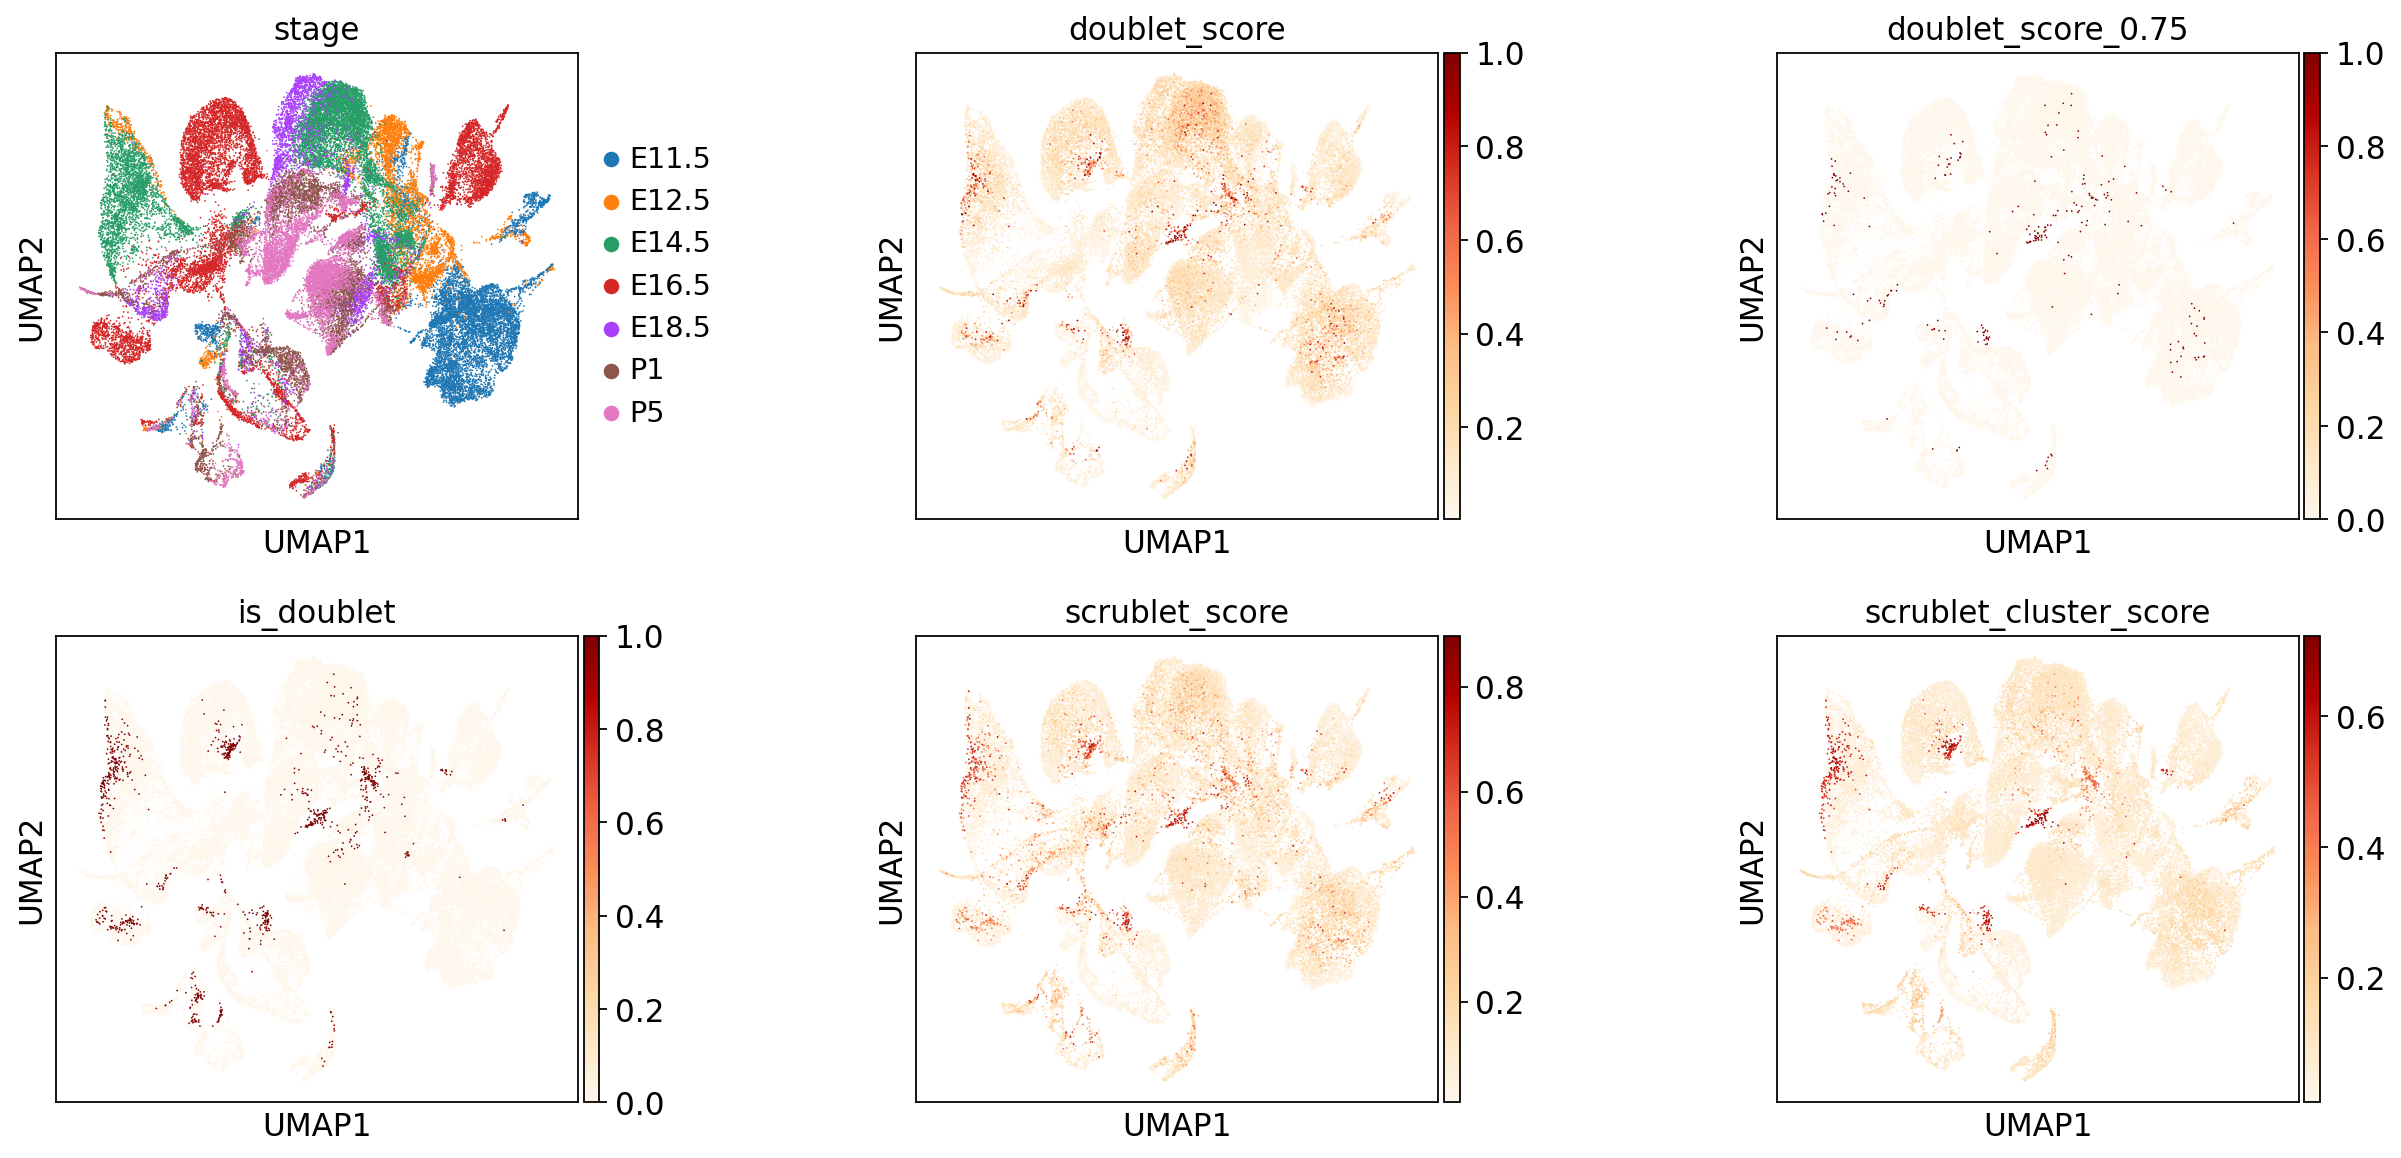

In [10]:
sc.pl.umap(adata, color=['stage', 'doublet_score','doublet_score_0.75', 'is_doublet', 'scrublet_score', 'scrublet_cluster_score'], ncols = 3, wspace = 0.5, color_map='OrRd',save='_doublet_scores.pdf')

In [11]:
# doublets %
print(adata.obs['doublet_score_0.75'].sum() / adata.shape[0])

0.005014108523984491


In [12]:
adata = adata[~adata.obs.is_doublet, :]
adata

View of AnnData object with n_obs × n_vars = 48287 × 3175 
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'stage', 'tissue', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'doublet_score_0.75', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'mouse_ENSEMBL-0', 'human_ENSEMBL-0', 'human_gene_ortholog-0', 'mouse_gene_name-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'mouse_ENSEMBL-1', 'human_ENSEMBL-1', 'human_gene_ortholog-1', 'mouse_gene_name-1', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'mouse_ENSEMBL-2', 'human_ENSEMBL-2', 'human_gene_ortholog-2', 'mouse_gene_name-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'mouse_ENSEMBL-3', 'human_ENSEMBL-3', 'human_gene_ortholog-3', 'mouse_gene_name-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'mouse_ENSEMBL-4', 'human_ENSEMBL-4', 'human_gene_ortholog-4', 'mouse_gene_name-4', 'gene_ids-5', 'feature_types-5', 

#### Save

In [13]:
adata.write('/nfs/team292/vl6/Mouse_Niu2020/preprocessing_afterDoublets.h5ad')

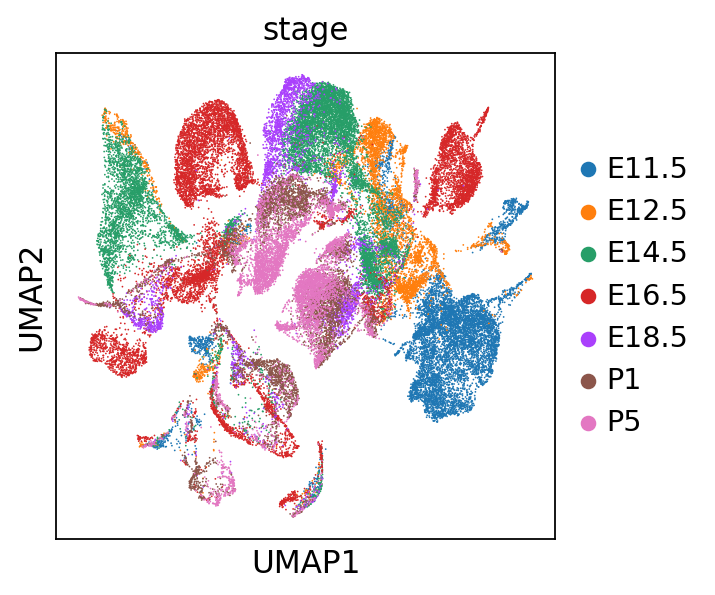

In [19]:
sc.pl.umap(adata, color = 'stage')

#### Harmonize

In [2]:
adata = sc.read('/nfs/team292/vl6/Mouse_Niu2020/preprocessing_afterDoublets.h5ad')

In [3]:
#adata = adata[[i not in ['E11.5', 'E16.5'] for i in adata.obs['stage']]]
adata

AnnData object with n_obs × n_vars = 48287 × 3175
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'stage', 'tissue', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'doublet_score_0.75', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'mouse_ENSEMBL-0', 'human_ENSEMBL-0', 'human_gene_ortholog-0', 'mouse_gene_name-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'mouse_ENSEMBL-1', 'human_ENSEMBL-1', 'human_gene_ortholog-1', 'mouse_gene_name-1', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'mouse_ENSEMBL-2', 'human_ENSEMBL-2', 'human_gene_ortholog-2', 'mouse_gene_name-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'mouse_ENSEMBL-3', 'human_ENSEMBL-3', 'human_gene_ortholog-3', 'mouse_gene_name-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'mouse_ENSEMBL-4', 'human_ENSEMBL-4', 'human_gene_ortholog-4', 'mouse_gene_name-4', 'gene_ids-5', 'feature_types-5', 'n_cells-

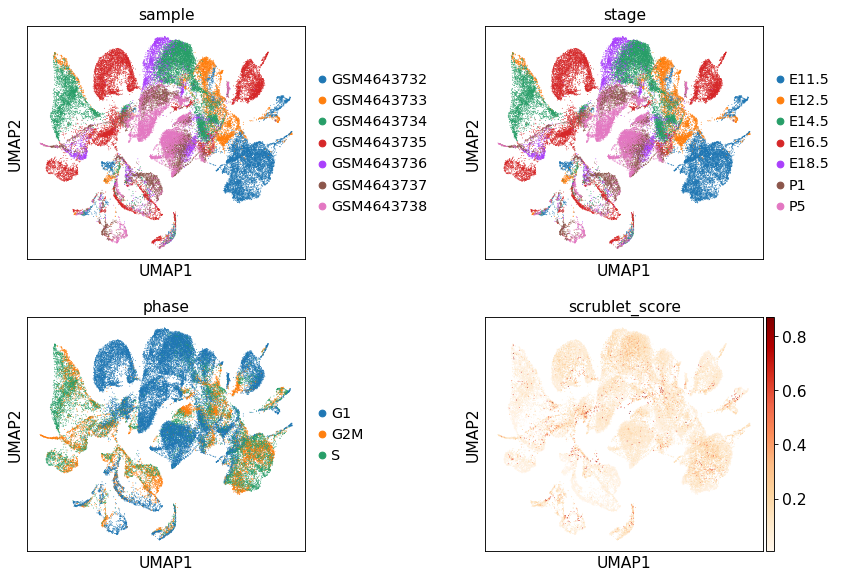

In [4]:
sc.pl.umap(adata, color = ['sample', 'stage', 'phase', 'scrublet_score'], use_raw = False, color_map = 'OrRd', ncols = 2, wspace = 0.5)

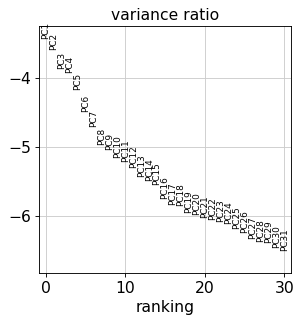

In [5]:
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

**Harmony integration**

In [6]:
# Extract PCA matrix and batch array
n_pcs = 26
pca = adata.obsm['X_pca'][:, 0:(n_pcs)]
batch = adata.obs['sample']

In [7]:
# Batch-correct the PCA using HARMONY method
%load_ext rpy2.ipython

In [8]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)
set.seed(1000)
hem <- HarmonyMatrix(pca, batch, theta=0, do_pca=FALSE, verbose = FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp



In [9]:
# Add harmony values to the anndata object
adata.obsm['X_pca'] = hem.values

In [10]:
# Visualize
sc.pp.neighbors(adata, n_pcs = n_pcs, random_state= 123)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 26
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:04:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:06:10)


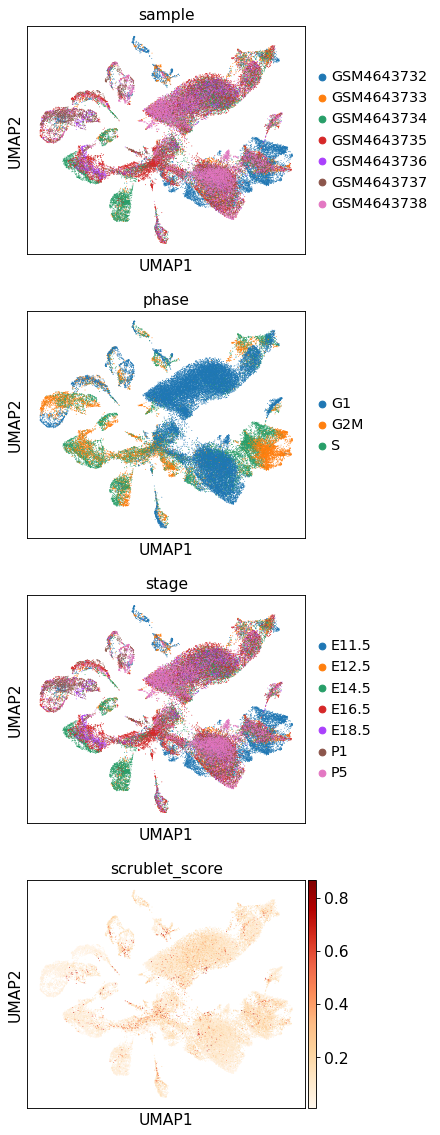

In [11]:
sc.pl.umap(adata, color=['sample', 'phase', 'stage', 'scrublet_score'], save='.pdf', ncols = 1, 
          color_map = 'OrRd')

**Cluster the manifold**

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:42)


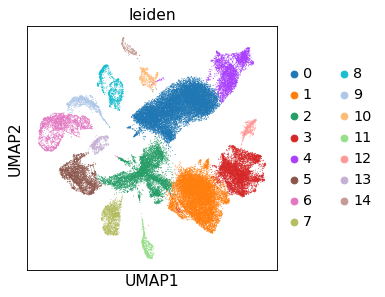

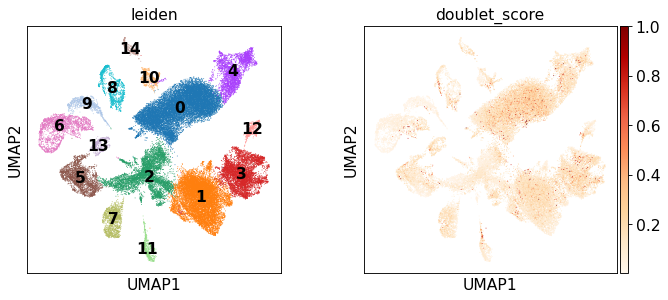

In [12]:
sc.tl.leiden(adata, resolution=0.25, random_state = 123)
sc.pl.umap(adata, color='leiden',save='_clustering.pdf')
sc.pl.umap(adata, color=['leiden', 'doublet_score'], color_map = 'OrRd',legend_loc='on data',save='_clustering_clusnumbers.pdf')

In [13]:
#### Gonads colors 
gonads_colors = ['#c466b0', '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb']

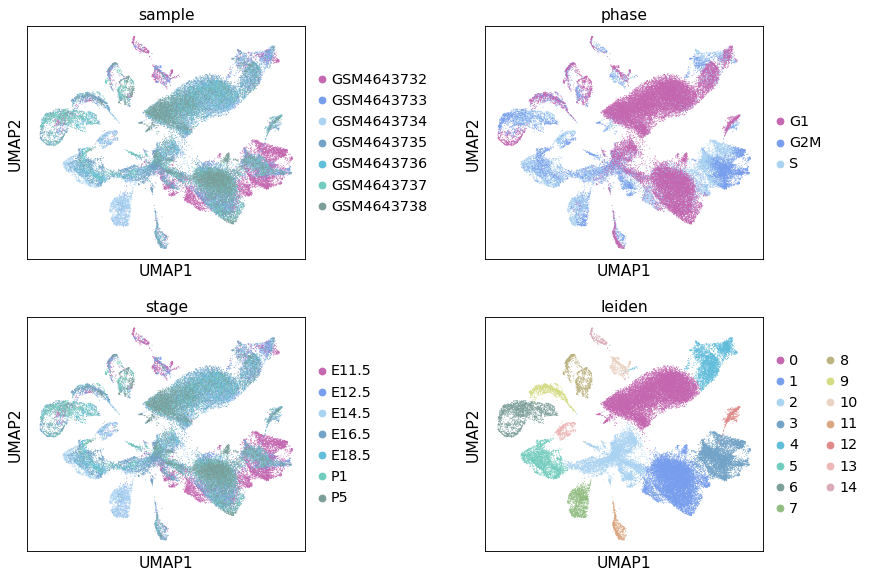

In [14]:
sc.pl.umap(adata, color=['sample', 'phase', 'stage', 'leiden'], save='.pdf', ncols = 2, wspace = 0.5,
          color_map = 'OrRd', palette = gonads_colors)

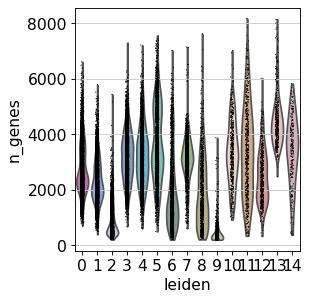

In [15]:
sc.pl.violin(adata, keys = ['n_genes'], groupby = 'leiden', save = '_ngenes.pdf')

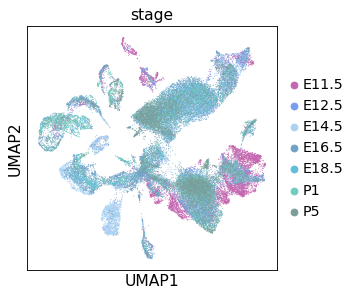

In [16]:
sc.pl.umap(adata, color = ['stage'])

**Assign cell types based on marker genes provided in the original paper**

In [17]:
adata.var.head()

gene_ids-0  feature_types-0  n_cells-0     mouse_ENSEMBL-0  \
MT-ATP8  ENSMUSG00000064356  Gene Expression     3729.0  ENSMUSG00000064356   
MT-ND3   ENSMUSG00000064360  Gene Expression     7862.0  ENSMUSG00000064360   
MT-ND5   ENSMUSG00000064367  Gene Expression     7020.0  ENSMUSG00000064367   
MT-ND6   ENSMUSG00000064368  Gene Expression      895.0  ENSMUSG00000064368   
PCDH11Y  ENSMUSG00000034755  Gene Expression      994.0  ENSMUSG00000034755   

         human_ENSEMBL-0 human_gene_ortholog-0 mouse_gene_name-0  \
MT-ATP8  ENSG00000228253               MT-ATP8           mt-Atp8   
MT-ND3   ENSG00000198840                MT-ND3            mt-Nd3   
MT-ND5   ENSG00000198786                MT-ND5            mt-Nd5   
MT-ND6   ENSG00000198695                MT-ND6            mt-Nd6   
PCDH11Y  ENSG00000099715               PCDH11Y           Pcdh11x   

                 gene_ids-1  feature_types-1  n_cells-1  ... n_cells-6  \
MT-ATP8  ENSMUSG00000064356  Gene Expression     1516.0  ...    1944.0   
MT-ND3   ENSMUSG00000064360  Gene Expression     4198.0  ...    5176.0   
MT-ND5   ENSMUSG00000064367  Gene Expression     3848.0  ...    4632.0   
MT-ND6   ENSMUSG00000064368  Gene Expression     1006.0  ...     748.0   
PCDH11Y  ENSMUSG00000034755  Gene Expression      644.0  ...     355.0   

            mouse_ENSEMBL-6  human_ENSEMBL-6 human_gene_ortholog-6  \
MT-ATP8  ENSMUSG00000064356  ENSG00000228253               MT-ATP8   
MT-ND3   ENSMUSG00000064360  ENSG00000198840                MT-ND3   
MT-ND5   ENSMUSG00000064367  ENSG00000198786                MT-ND5   
MT-ND6   ENSMUSG00000064368  ENSG00000198695                MT-ND6   
PCDH11Y  ENSMUSG00000034755  ENSG00000099715               PCDH11Y   

        mouse_gene_name-6 n_cells  highly_variable     means dispersions  \
MT-ATP8           mt-Atp8   24909             True  0.937469    1.595168   
MT-ND3             mt-Nd3   44093             True  2.330981    2.012161   
MT-ND5             mt-Nd5   41259             True  2.024741    2.261454   
MT-ND6             mt-Nd6   14149             True  0.911457    2.887865   
PCDH11Y           Pcdh11x    4358             True  0.167457    1.382097   

        dispersions_norm  
MT-ATP8         0.437470  
MT-ND3          0.518457  
MT-ND5          0.339323  
MT-ND6          3.040956  
PCDH11Y         0.417479  

[5 rows x 54 columns]

In [18]:
markers = ['Ddx4', 'Dazl', 'Nanog', 'Sycp3', 'Wnt6', 'Wnt4', 'Kitl', 'Foxl2','Upk3b', 'Krt19','Epcam',  'Nr2f2', 'Col1a1', 'Dcn',  'Car2','Tyrobp',  
           'Cdh5', 'Vwf', 'Cd3f']
mouse_gene_to_human = pd.Series(adata.var['human_gene_ortholog-0'].values, index=adata.var['mouse_gene_name-0']).to_dict()

In [19]:
markers_present = []
for gene in markers:
    if gene in mouse_gene_to_human:
                markers_present.append(mouse_gene_to_human[gene])

In [20]:
markers_present

['DDX4',
 'DAZ1',
 'WNT6',
 'WNT4',
 'KITLG',
 'FOXL2',
 'UPK3B',
 'KRT19',
 'EPCAM',
 'NR2F2',
 'COL1A1',
 'DCN',
 'CA2',
 'TYROBP',
 'CDH5']

In [37]:
markers_present = ['POU5F1', 'DDX4',
 'DAZ1',  'STRA8',  'SYCE3',  'UPK3B',
 'KRT19','KITLG', 'WNT6', 'WNT4', 'FOXL2',


 'NR2F2',
 'COL1A1',
 'DCN',  'EPCAM','CDH5', 'TYROBP',
 'CA2',
 
 ]

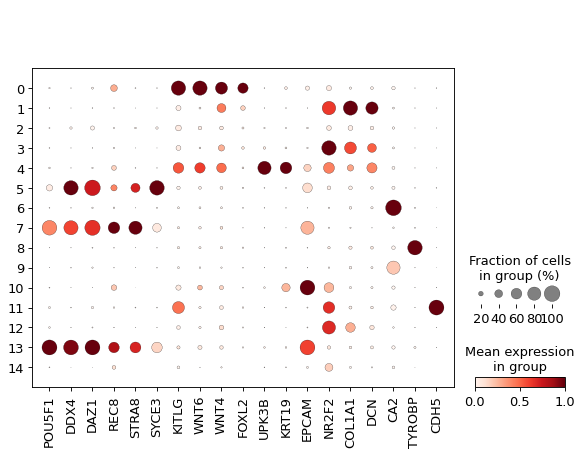

In [22]:
sc.pl.dotplot(adata, var_names = markers_present, groupby = 'leiden', standard_scale = 'var', save = '_mouse_markers.pdf')

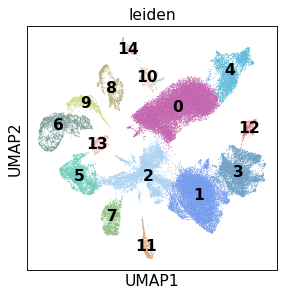

In [23]:
sc.pl.umap(adata, color='leiden', legend_loc = 'on data')

 * Clusters 2 has very low genes detected (see violin plot) and has no markers
 * Cluster 6, 9 has very low genes detected but expresses marker of erythroid cells, which biologically is a good reason for having low numbers of genes detected
 * Clusters 5, 7, 13 are germ cells 
 * Cluster 10 are epithelial cells
 * Cluster 0 are supporting cells
 * Cluster 4 are mesothelial cells
 * Clusters 1, 3, 12, 14 are mesenchymal cells 
 * Cluster 11 are endothelial cells 
 * Cluster 8 are macrophages 


In [33]:
cell_types = {'2' : 'lowQC', '6' : 'Erythroid',  '9' : 'Erythroid', '5' : 'Germ cells',  '7' : 'Germ cells', 
               '13' : 'Germ cells', '4' : 'Mesothelial', 
             '0' : 'Supporting', '10' : 'Epithelial', '1' : 'Mesenchymal', '3' : 'Mesenchymal', '12' : 'Mesenchymal',
              '14' : 'Mesenchymal', 
             '11' : 'Endothelial', '8' : 'Myeloid'}
adata.obs['cell_type'] = adata.obs['leiden'].map(cell_types)
adata.obs['cell_type'].value_counts(dropna = False)

Mesenchymal    16519
Supporting     13930
lowQC           5352
Germ cells      4208
Mesothelial     3211
Erythroid       2969
Myeloid         1009
Epithelial       547
Endothelial      542
Name: cell_type, dtype: int64

In [34]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')

In [35]:
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories(['Germ cells',
                                                                        'Mesothelial', 'Supporting', 'Mesenchymal', 'Epithelial',
                                                                         
                                                                        'Endothelial', 'Myeloid', 'Erythroid','lowQC'])

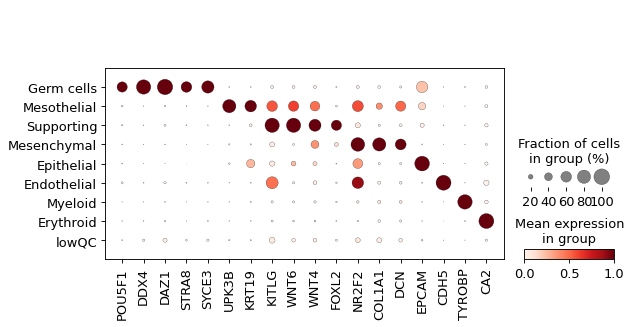

In [38]:
sc.pl.dotplot(adata, var_names = markers_present, groupby = 'cell_type', standard_scale = 'var', save = '_mouse_markers_celltype')

In [43]:
#### Gonads colors 
gonads_colors = ['#ff0000',  # germs
                  '#366b36', # sup
                  '#d9439a', # preGC
                  '#fcbdc4', # Gi and Oi
                  '#d98200', '#e36a1e',  '#ffb485', '#ffd919', '#c4c4c2']

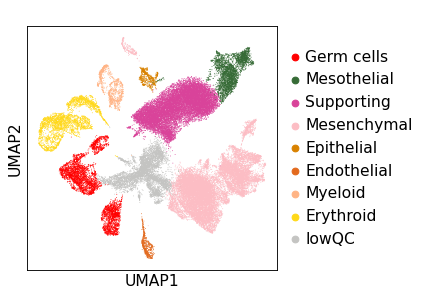

In [45]:
sc.pl.umap(adata, color = ['cell_type'], palette = gonads_colors,  frameon = True, title = " ",
           legend_fontsize = 'medium', legend_fontweight = 'medium', save = '_celltype')

In [46]:
stage_gradient = ['#6C818C', '#51829D', '#3D83A9', '#649CBA', '#8BB5CB', '#B1CDDD', '#D8E6EE']

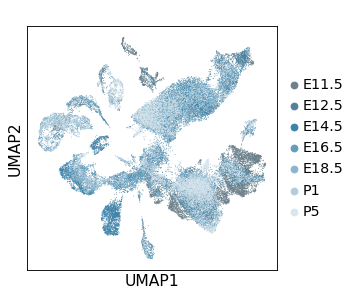

In [47]:
sc.pl.umap(adata, color = 'stage', palette = stage_gradient, save = "_stage_all", title = " ")

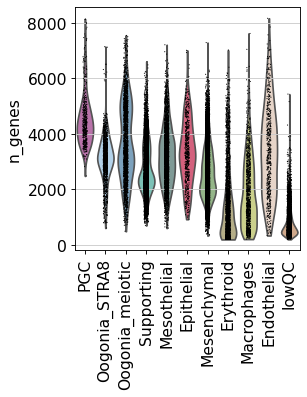

In [32]:
sc.pl.violin(adata, keys = ['n_genes'], groupby = 'cell_type', rotation = 90, save = '_ngenes.pdf')

In [33]:
adata.shape

(48287, 3175)

In [34]:
adata.write("/nfs/team292/vl6/Mouse_Niu2020/mouse_annotated.h5ad")

In [2]:
adata = sc.read("/nfs/team292/vl6/Mouse_Niu2020/mouse_annotated.h5ad")

#### TF-IDF

In [3]:
import rpy2.rinterface_lib.callbacks
import logging
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [4]:
import anndata
adata = anndata.AnnData(X = adata.raw.X, var = adata.raw.var, obs = adata.obs)

In [5]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 15799 48287 
metadata(0):
assays(1): X
rownames(15799): MT-ND1 MT-ND2 ... KPNA7 CABP7
rowData names(50): gene_ids.0 feature_types.0 ... mouse_gene_name.6
  n_cells
colnames(48287): GSM4643732_E11.5gonad_AAACCTGAGACAAGCC
  GSM4643732_E11.5gonad_AAACCTGAGCGGATCA ...
  GSM4643738_P5ovary_TTTGTCATCATTTGGG
  GSM4643738_P5ovary_TTTGTCATCCGCATAA
colData names(20): batch n_counts ... leiden cell_type
reducedDimNames(0):
altExpNames(0):


In [6]:
%%R -o mrks

library(SoupX)
counts <- assay(adata, "X")
colnames(counts) <- colnames(adata)
rownames(counts) <- rownames(adata)
mrks = quickMarkers(counts, colData(adata)$cell_type, N = 100) # where clusters is the cell type assignment and 20 means I want the top 20 genes per cluster that pass the hypergeometric test

In [7]:
mrks

gene cluster  geneFrequency  geneFrequencyOutsideCluster  \
1        DPPA4     PGC       0.816372                     0.034724   
2        FOXR1     PGC       0.750000                     0.025483   
3         SOX2     PGC       0.798673                     0.034703   
4        SALL4     PGC       0.871681                     0.048709   
5        AP3B2     PGC       0.721239                     0.025024   
...        ...     ...            ...                          ...   
1003  C14orf39   lowQC       0.192451                     0.150017   
1004      DAZ1   lowQC       0.168722                     0.133481   
1005     STK31   lowQC       0.137145                     0.110073   
1006   HORMAD1   lowQC       0.112108                     0.088226   
1007      CTSG   lowQC       0.008595                     0.003354   

      geneFrequencySecondBest  geneFrequencyGlobal secondBestClusterName  \
1                    0.643786             0.042040         Oogonia_STRA8   
2                    0.559971             0.032265         Oogonia_STRA8   
3                    0.729046             0.041854         Oogonia_STRA8   
4                    0.767341             0.056413         Oogonia_STRA8   
5                    0.421965             0.031541         Oogonia_STRA8   
...                       ...                  ...                   ...   
1003                 0.971332             0.154721       Oogonia_meiotic   
1004                 0.993255             0.137387       Oogonia_meiotic   
1005                 0.981450             0.113074       Oogonia_meiotic   
1006                 0.924115             0.090873       Oogonia_meiotic   
1007                 0.058474             0.003935           Macrophages   

         tfidf       idf          qval  
1     2.587185  3.169127  0.000000e+00  
2     2.575320  3.433759  0.000000e+00  
3     2.534643  3.173570  0.000000e+00  
4     2.506137  2.875061  0.000000e+00  
5     2.492948  3.456480  0.000000e+00  
...        ...       ...           ...  
1003  0.359140  1.866134  9.539075e-12  
1004  0.334905  1.984954  1.299028e-08  
1005  0.298937  2.179714  1.552341e-05  
1006  0.268866  2.398289  3.691147e-05  
1007  0.047598  5.537894  5.494555e-04  

[1007 rows x 10 columns]

In [8]:
mrks.to_csv("/home/jovyan/MouseNiu_markersTFIDF.csv")

#### Save supporting cells + mesothelial 

In [54]:
supp_meso = adata[[i in ['Supporting', 'Mesothelial', 'Epithelial'] for i in adata.obs['cell_type']]]
print(supp_meso.shape)
supp_meso.write("/nfs/team292/vl6/Mouse_Niu2020/supporting_mesothelial.h5ad")

(17686, 3175)


#### Save mesenchymal 

In [145]:
mese = adata[[i in ['1', '3', '12'] for i in adata.obs['leiden']]]
print(mese.shape)
mese.write("/nfs/team292/vl6/Mouse_Niu2020/mesenchymal.h5ad")

(16298, 3175)


#### Save germ cells

In [35]:
germcells = adata[[i in ['PGC', 'Oogonia_STRA8', 'Oogonia_meiotic'] for i in adata.obs['cell_type']]]
print(germcells.shape)
germcells.write("/nfs/team292/vl6/Mouse_Niu2020/germcells.h5ad")

(4208, 3175)


#### Normalize and log-transform (but don't scale)

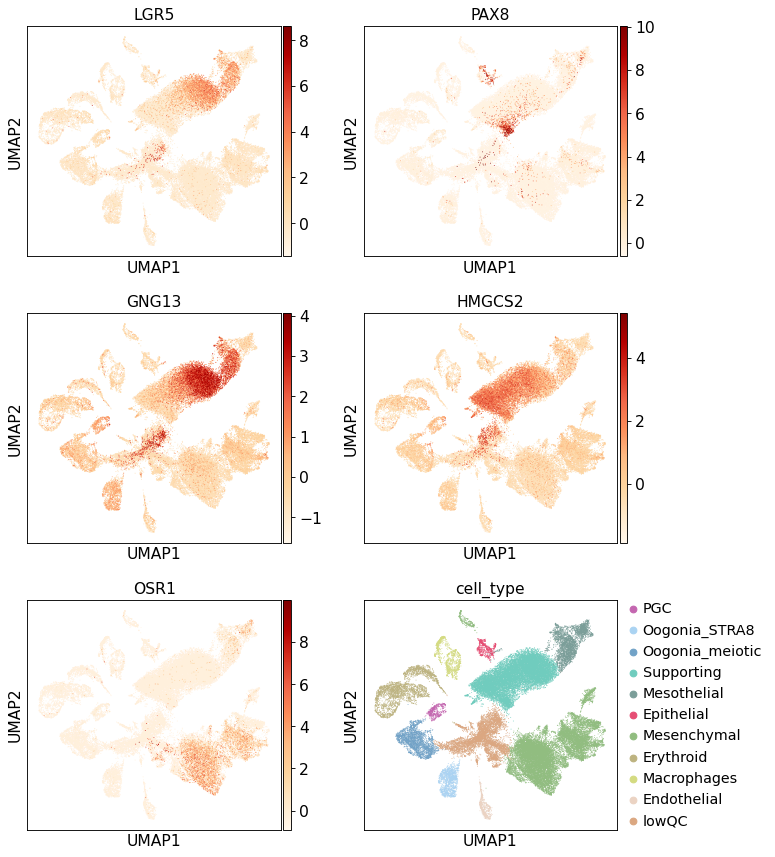

In [7]:
sc.pl.umap(adata, color = ['LGR5', 'PAX8', 'GNG13', 'HMGCS2', 'OSR1', 'cell_type'], ncols = 2, color_map = 'OrRd', use_raw = False)

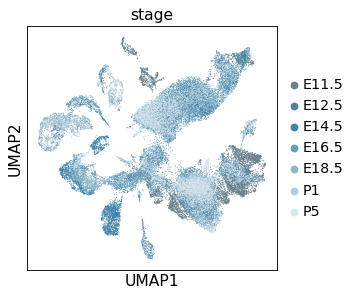

In [13]:
sc.pl.umap(adata, color = ['stage'])

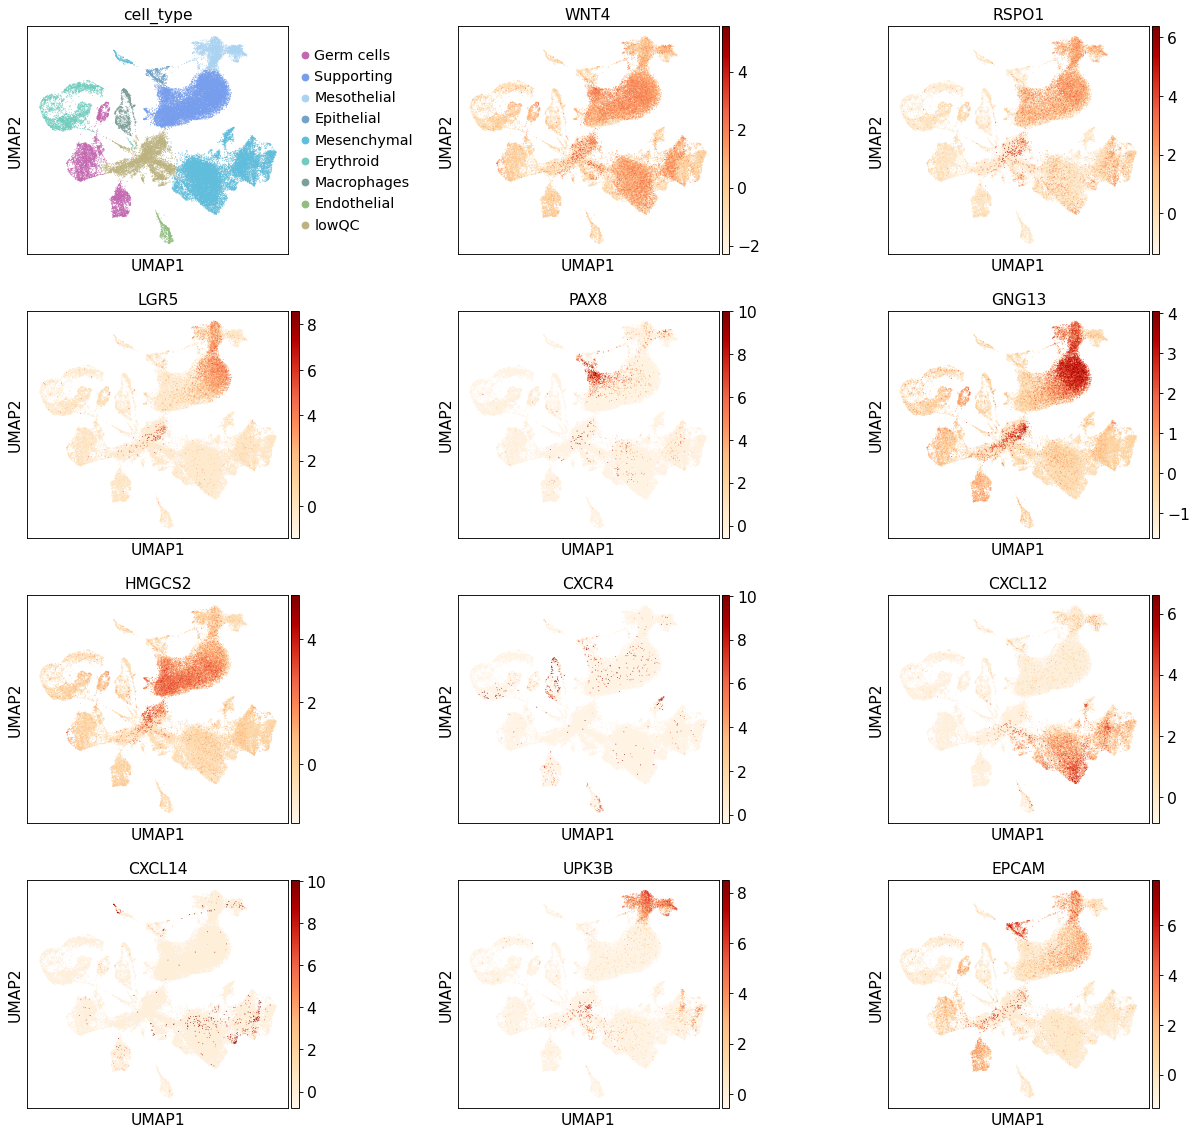

In [125]:
sc.pl.umap(adata, color = ['cell_type', 'WNT4', 'RSPO1',
                          'LGR5', 'PAX8', 'GNG13', 'HMGCS2', 'CXCR4', 'CXCL12', 'CXCL14', 'UPK3B', 'EPCAM'], ncols = 3, color_map = 'OrRd', use_raw = False, wspace = 0.5)

#### Import TF-IDF markers for PAX8 human population

In [127]:
human_markers = pd.read_csv("/home/jovyan/Gonads/Mouse_Niu_2020/supporting_TFIDF.csv", index_col = 0)
human_markers.head()

cluster  geneFrequency  geneFrequencyOutsideCluster  \
gene                                                         
POSTN  coelEpi          0.609                     0.045273   
UPK3B  coelEpi          0.858                     0.133091   
GPC3   coelEpi          0.697                     0.084909   
TNNT1  coelEpi          0.654                     0.083000   
KLK11  coelEpi          0.711                     0.104273   

       geneFrequencySecondBest  geneFrequencyGlobal secondBestClusterName  \
gene                                                                        
POSTN                      NaN             0.092250       coelEpi_cycling   
UPK3B                      NaN             0.193500           ovarianSurf   
GPC3                       NaN             0.135917       coelEpi_cycling   
TNNT1                      NaN             0.130583           ovarianSurf   
KLK11                      NaN             0.154833           ovarianSurf   

          tfidf       idf  qval  
gene                             
POSTN  1.451401  2.383253   0.0  
UPK3B  1.409246  1.642478   0.0  
GPC3   1.391012  1.995713   0.0  
TNNT1  1.331376  2.035744   0.0  
KLK11  1.326304  1.865406   0.0

In [128]:
human_markers.cluster.value_counts()

sLGR5              6154
preGCc_CSRNP1      5170
ovarianSurf        5156
preGC_RDH10        5109
coelEpi_cycling    4696
coelEpi            3273
Sertoli_cycling    2938
preGCm_OSR1        2654
sKITLG             2316
Sertoli_NR4A1      2285
sPAX8               879
Sertoli             228
Name: cluster, dtype: int64

In [129]:
pax8_human = human_markers[human_markers['cluster'] == 'sPAX8']
pax8_human.head()

cluster  geneFrequency  geneFrequencyOutsideCluster  \
gene                                                       
PAX8   sPAX8          0.750                     0.044182   
CALY   sPAX8          0.601                     0.030455   
PLAU   sPAX8          0.563                     0.030545   
SST    sPAX8          0.577                     0.045182   
NRGN   sPAX8          0.509                     0.027091   

      geneFrequencySecondBest  geneFrequencyGlobal secondBestClusterName  \
gene                                                                       
PAX8                      NaN             0.103000               coelEpi   
CALY                      NaN             0.078000       Sertoli_cycling   
PLAU                      NaN             0.074917               coelEpi   
SST                       NaN             0.089500           preGC_RDH10   
NRGN                      NaN             0.067250       coelEpi_cycling   

         tfidf       idf  qval  
gene                            
PAX8  1.704770  2.273026   0.0  
CALY  1.533179  2.551046   0.0  
PLAU  1.458946  2.591379   0.0  
SST   1.392599  2.413517   0.0  
NRGN  1.373963  2.699338   0.0

In [130]:
pax8_human_markers = list(pax8_human.index)[0:100]
pax8_human_markers = [i for i in pax8_human_markers if i in adata.var_names]
len(pax8_human_markers)

54